In [62]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import random



In [63]:
df_train = pd.read_csv("../input/data/train/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


In [64]:
df_train.sample(5)

,id,gender,race,age,path
1415,003463,male,Asian,57,003463_male_Asian_57
1439,003507,male,Asian,57,003507_male_Asian_57
1852,004333,male,Asian,57,004333_male_Asian_57
1636,003805,male,Asian,56,003805_male_Asian_56
2320,006162,male,Asian,20,006162_male_Asian_20


In [65]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2700.0,37.708148,16.985904,18.0,20.0,36.0,55.0,60.0


- 결측치 확인 -> 없음

In [66]:
df_train.isnull().sum()

id        0
gender    0
race      0
age       0
path      0
dtype: int64

<AxesSubplot:>

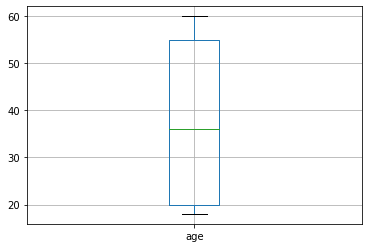

In [67]:
df_train.boxplot()

In [68]:
# 인종은 Asian만 있어 불필요한 컬럼
df_train['race'].unique()

array(['Asian'], dtype=object)

- 성별은 약 4:6의 불균형이 있다.

female    1658
male      1042
Name: gender, dtype: int64


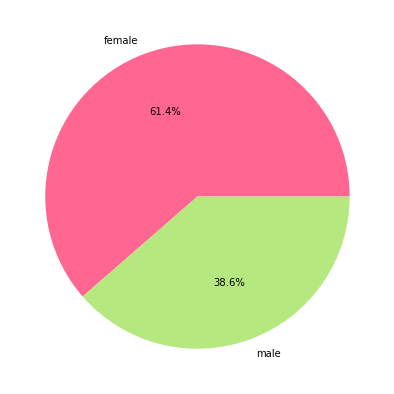

In [86]:
gender_cnt = df_train['gender'].value_counts()
print(gender_cnt)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pie(gender_cnt, 
       labels=['female', 'male'], 
       autopct='%1.1f%%',
       colors=['#FF6692', '#B6E880'])
plt.show()

In [70]:
# 인당 마스크를 쓴 이미지 5개, 쓰지 않은 이미지 1개, 제대로 착용하지 않은 이미지 1개씩이 있다.
# os에 따라 불필요한 파일이 있다면 삭제
img_path = '../input/data/train/images'
tmp = os.listdir(img_path + '/' + df_train["path"][0])
tmp

['incorrect_mask.jpg',
 'mask1.jpg',
 'mask2.jpg',
 'mask3.jpg',
 'mask4.jpg',
 'mask5.jpg',
 'normal.jpg']

In [71]:
# '._'으로 시작하는 불필요한 파일 삭제
# mac -> window로 파일을 옮기면 생기는 메타데이터로 지워도 무방하다고 한다.
rm = False; os_window = True
if rm:
    for (path, dir, files) in os.walk(img_path):
        for filename in files:
            ext = os.path.splitext(filename)[0]
            if os_window:
                if ext.startswith('._'):
                    # print(os.path.join(path, filename))
                    os.remove(os.path.join(path, filename))
            else:
                if not ext.startswith('._'):
                    # print(os.path.join(path, filename))
                    os.remove(os.path.join(path, filename))

- 렌덤으로 출력해보기

In [72]:
# c = 7로 고정
r, c = 3, 7
fig, axes = plt.subplots(r, c, figsize = (15,3*r))

for i in range(r):
    n = random.randint(0,len(df_train))
    for j in range(c):
        axes[i][j].set_title(tmp[j])
        tmp = os.listdir(img_path + '/' + df_train["path"][n])
        img = plt.imread(img_path + '/' + df_train["path"][n]+ '/'+tmp[j])
        axes[i][j].imshow(img)
        axes[i][j].set_xticks([]); axes[i][j].set_yticks([])

plt.show()

# 이미지를 직접 살펴본 결과
1. incorrect의 기준은 입과 코를 모두 잘 덮었는가 여부이다.
2. 배경은 단색, 야외, 글씨가 있는 배경 등 다양하다. (배경이 영향이 있을까?)
3. 1개의 마스크 종류를 사용한 사람도 있고, 여러 개 사용한 사람도 있다.
4. 구도는 거의 유사하지만 미세하게 다른 경우도 존재한다.
5. 같은 사람의 사진이라도 밝기 정도가 경우가 존재한다.

In [73]:
df_train.iloc[0]

id                        000001
gender                    female
race                       Asian
age                           45
path      000001_female_Asian_45
Name: 0, dtype: object

In [74]:
# 조정한 df_train_adj 생성
# id, age: 그대로 / race: 삭제
# gender: (M,F) = (0,1)
# path: 이미지별 path로 통합
# mask: (incorrect, correct, normal) = (0,1,2)
# extention: 확장자
img_path = '../input/data/train/images'
id = []
gender = []
age = []
path = []
mask = []
extension = []

for i in range(len(df_train)):
    tmp = df_train.iloc[i]
    id_ = tmp['id']
    gender_ = int(tmp['gender']=='female')
    age_ = tmp['age']
    path1 =  tmp["path"]
    for j, path2 in enumerate(os.listdir(img_path + '/' + path1)):
        name, ext = path2.split('.')
        for k, x in enumerate(['incorrect','mask','normal']):
            if name.startswith(x):
                mask.append(k)
        extension.append(ext)
        path.append(path1 + '/' + path2)
        id.append(id_)
        gender.append(gender_)
        age.append(age_)



In [75]:
df_train_adj = pd.DataFrame(data = zip(id,path,extension,age,mask,gender), columns = ['id','path','extension','age','mask','gender'])

In [76]:
df_train_adj.sample(10)

,id,path,extension,age,mask,gender
18585,006728,006728_male_Asian_19/incorrect_mask.jpg,jpg,19,0,0
2556,000817,000817_female_Asian_52/mask1.jpg,jpg,52,1,1
746,000280,000280_female_Asian_54/mask4.jpg,jpg,54,1,1
1686,000642,000642_female_Asian_54/normal.jpg,jpg,54,2,1
16038,006106,006106_male_Asian_19/mask1.jpg,jpg,19,1,0
9545,003392,003392_female_Asian_19/mask4.jpg,jpg,19,1,1
6531,001720,001720_female_Asian_18/incorrect_mask.jpg,jpg,18,0,1
883,000334,000334_female_Asian_52/mask1.jpg,jpg,52,1,1
5944,001594,001594_male_Asian_58/mask1.jpg,jpg,58,1,0
12928,004324,004324_female_Asian_60/normal.jpg,jpg,60,2,1


In [77]:
# id가 겹치는 오류가 하나 있다.
df_train_adj[df_train_adj['id']=='003397']

,id,path,extension,age,mask,gender
9562,003397,003397_female_Asian_20/incorrect_mask.jpg,jpg,20,0,1
9563,003397,003397_female_Asian_20/mask1.jpg,jpg,20,1,1
9564,003397,003397_female_Asian_20/mask2.jpg,jpg,20,1,1
9565,003397,003397_female_Asian_20/mask3.jpg,jpg,20,1,1
9566,003397,003397_female_Asian_20/mask4.jpg,jpg,20,1,1
9567,003397,003397_female_Asian_20/mask5.jpg,jpg,20,1,1
9568,003397,003397_female_Asian_20/normal.jpg,jpg,20,2,1
9569,003397,003397_female_Asian_19/incorrect_mask.jpg,jpg,19,0,1
9570,003397,003397_female_Asian_19/mask1.jpg,jpg,19,1,1
9571,003397,003397_female_Asian_19/mask2.jpg,jpg,19,1,1


In [78]:
df_train_adj['mask'].value_counts()

1    13500
0     2700
2     2700
Name: mask, dtype: int64

In [79]:
# 확장자가 (동일인에 대해서도) 일정하지 않은 경우가 존재한다.
df_train_adj['extension'].value_counts()

jpg     18035
png       511
jpeg      354
Name: extension, dtype: int64

In [80]:
# age 카테고리화
# (30세 미만, 30세 이상 60세 미만, 60세 이상) = (0,1,2)
df_train_adj['age_class'] = pd.cut(df_train_adj['age'], bins = [0,30,60,1000], right=False, labels = [0,1,2])

- 60세의 데이터가 많이 부족하다.

0    8967
1    8589
2    1344
Name: age_class, dtype: int64


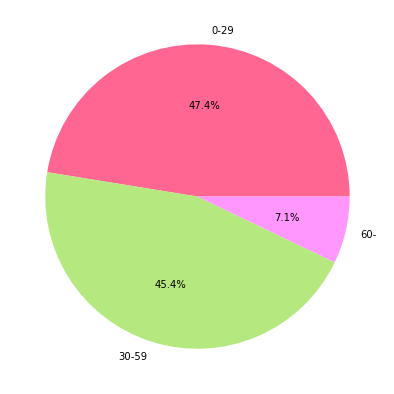

In [82]:
age_cnt = df_train_adj['age_class'].value_counts()
print(age_cnt)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pie(age_cnt, 
       labels=['0-29', '30-59', '60-'], 
       autopct='%1.1f%%',
       colors=['#FF6692', '#B6E880', '#FF97FF'])
plt.show()

- 20세 내외와 50, 60대에 대부분의 분포가 몰려있음을 확인할 수 있었다.

<AxesSubplot:xlabel='age', ylabel='count'>

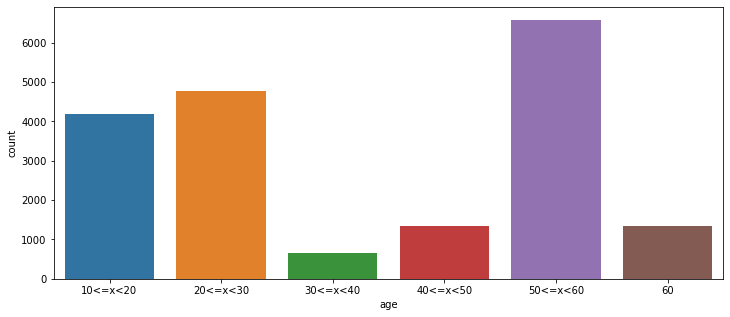

In [83]:
plt.figure(figsize = (12,5))
sns.countplot(x = pd.cut(df_train_adj['age'], bins = [10,20,30,40,50,60,1000], right=False, 
labels = ['10<=x<20','20<=x<30','30<=x<40','40<=x<50','50<=x<60','60']))

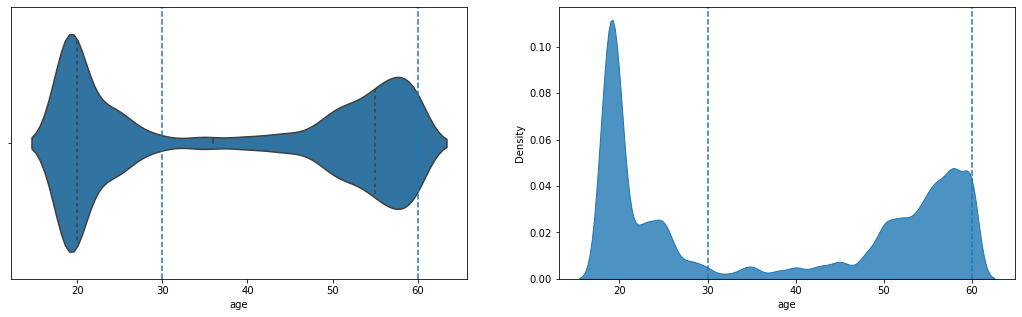

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

plot1 = sns.violinplot(data=df_train_adj, x='age', ax=axes[0], bw=0.1, inner='quartile')
plot2 = sns.kdeplot(data=df_train_adj, x='age', fill=True, alpha=0.8, ax=axes[1], bw_method=0.05)

axes[0].axvline(30, linestyle='--')
axes[0].axvline(60, linestyle='--')

axes[1].axvline(30, linestyle='--')
axes[1].axvline(60, linestyle='--')

# 정답 레이블
![image](https://user-images.githubusercontent.com/85151359/154933965-46470529-1a76-44e3-aeeb-e77e35728d88.png)

In [85]:
# 정답 레이블(ans) 생성용 dict
dic_ans = dict()
keys = [(i,j,k) for i in [1,0,2] for j in range(2) for k in range(3)]
labels = range(18)
for x,y in zip(keys,labels):
    dic_ans[x]=y

In [60]:
# 정답 레이블 컬럼 추가
df_train_adj['ans'] = [dic_ans[tuple(df_train_adj[['mask','gender','age_class']].iloc[i])] for i in range(len(df_train_adj))]

- 정답 레이블의 비율을 살펴보면, 아래처럼 나이대와 마스크 착용 여부에 따른 불균형이 심하다.

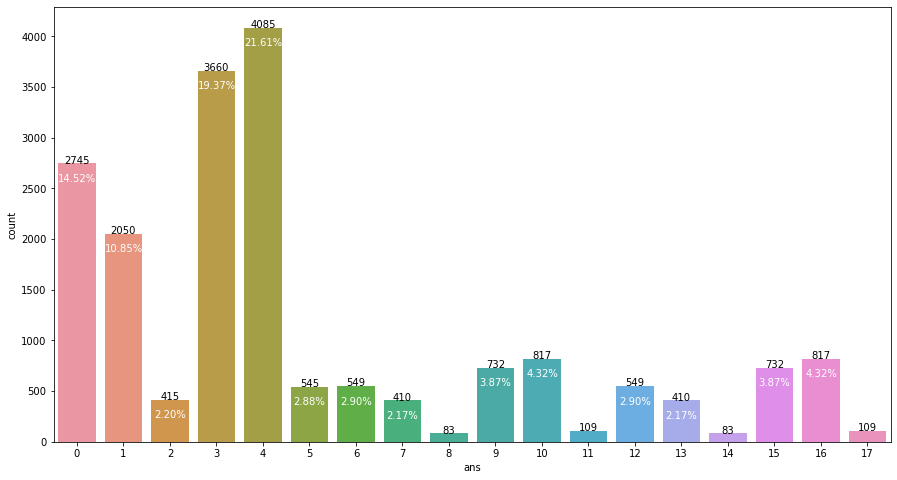

In [61]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax = sns.countplot(x=df_train_adj["ans"], ax=ax)
for patch in ax.patches:
    ax.annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), ha='center')
    if patch.get_height() > 200:
        ax.annotate(f'{patch.get_height() / len(df_train_adj) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - 100), color='white', va='top', ha='center')

## 결론

#### 분류 모델의 성능을 높이려면 아래 문제를 해결해야 할 것으로 보입니다.

1. 데이터의 불균형
   - 나이대, 성별, 마스크 착용 상태 관점에서 모두 데이터가 한쪽으로 편향되어 있다.
   - 이를 해결하려면 over sampling이 요구되는데, 그러면 데이터를 어떻게 확보할 수 있을까?
   - Data Augmentation으로 마스크를 제대로 착용하지 않거나 미착용한 상태의 이미지를 늘리는 방법이 있어 보인다.
2. 데이터 부족
    - 학습 데이터가 약 1만 개인데 반해, 18개의 레이블로 데이터를 분류해야 하는 건 쉽지 않아 보인다.
    - 마찬가지로 Data Augmentation으로 이를 보완할 수 있을 것 같다.
3. 모델 제작 방법
    - 18개의 레이블로 데이터를 분류하는 모델 한 개를 만들어야 할까?
    - 아니면 나이대, 성별, 마스크 착용 상태를 각각 분류하는 모델 세 개를 따로 만들어야 할까?